In [ ]:
import tushare as ts
from torch.onnx.symbolic_opset9 import tensor
from torch.utils.data import TensorDataset

ts.set_token('7122dc5841d8b75f04fce6aef20fc6bcca4e97c5e525bc4b791c02d4')

pro = ts.pro_api()
df = pro.daily(ts_code='600030.SH', start_date='20200101', end_date='20211231')
df.to_csv('../data/600030.csv', index=False)

In [1]:
from matplotlib import pyplot as plt
import pandas as pd

df = pd.read_csv('../data/600030.csv', parse_dates=['trade_date'], index_col='trade_date')
df.sort_index(ascending=True, inplace=True)
data = df['close']



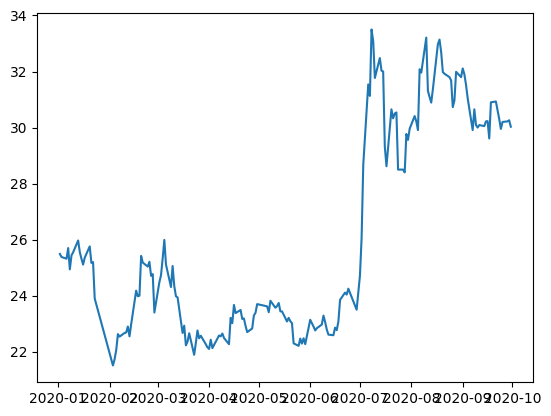

In [61]:
train_data = data['2020-01-01':'2020-10-01']
plt.plot(train_data)

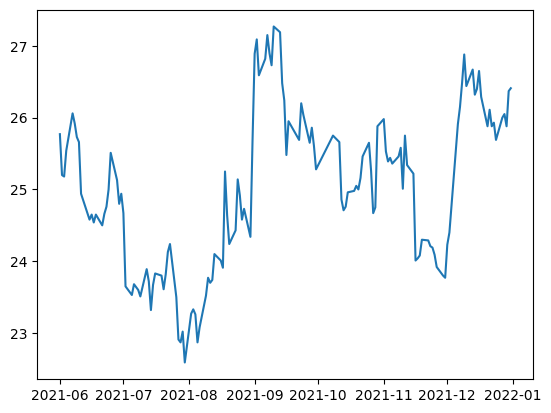

In [73]:
test_data = data['2021-06-01':'2021-12-31']
plt.plot(test_data)

In [62]:
import numpy as np

train_data_values = train_data.values

days = 3

x_train_data = []
y_train_data = []

for i in range(days, len(train_data_values)):
    x_train_data.append(train_data_values[i - days:i])
    y_train_data.append(train_data_values[i])

train_x = np.array(x_train_data)
train_y = np.array(y_train_data)

x_train_data_max_min = (train_x - train_x.min()) / (train_x.max() - train_x.min())
y_train_data_max_min = (train_y - train_y.min()) / (train_y.max() - train_y.min())

In [63]:
from torch.utils.data import TensorDataset, DataLoader
import torch

train_dataset = TensorDataset(torch.tensor(x_train_data_max_min, dtype=torch.float32),
                              torch.tensor(y_train_data_max_min, dtype=torch.float32).unsqueeze(1))
dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [81]:
from torch import nn
import torch


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


Model = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

step = 1000

for epoch in range(step):
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = Model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    print(f'epoch:{epoch + 1}, loss:{loss.item()}')

epoch:1, loss:0.03870673477649689
epoch:2, loss:0.02656201273202896
epoch:3, loss:0.013051982969045639
epoch:4, loss:0.003294057445600629
epoch:5, loss:0.0016274151857942343
epoch:6, loss:0.0014335433952510357
epoch:7, loss:0.013769797049462795
epoch:8, loss:0.004090512171387672
epoch:9, loss:0.009551390074193478
epoch:10, loss:0.011196982115507126
epoch:11, loss:0.00035337236477062106
epoch:12, loss:0.0008913233759813011
epoch:13, loss:0.002642316510900855
epoch:14, loss:0.002968704793602228
epoch:15, loss:0.002505113137885928
epoch:16, loss:0.00036012171767652035
epoch:17, loss:0.0012501043966040015
epoch:18, loss:0.0006248474819585681
epoch:19, loss:0.000194339343579486
epoch:20, loss:0.0017905023414641619
epoch:21, loss:0.001505122403614223
epoch:22, loss:0.0028989880811423063
epoch:23, loss:0.0027338219806551933
epoch:24, loss:0.0033264143858104944
epoch:25, loss:0.00034888979280367494
epoch:26, loss:0.010791251435875893
epoch:27, loss:0.0020569718908518553
epoch:28, loss:0.004972

In [82]:
test_data_values = test_data.values
x_test_data = []
y_test_data = []
for i in range(days, len(test_data_values)):
    x_test_data.append(test_data_values[i - days:i])
    y_test_data.append(test_data_values[i])

x_test_data_max_min = (np.array(x_test_data) - train_x.min()) / (train_x.max() - train_x.min())
y_test_data_max_min = (np.array(y_test_data) - train_y.min()) / (train_y.max() - train_y.min())
test_dataset = TensorDataset(torch.tensor(x_test_data_max_min, dtype=torch.float32),
                             torch.tensor(y_test_data_max_min, dtype=torch.float32).unsqueeze(1))

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

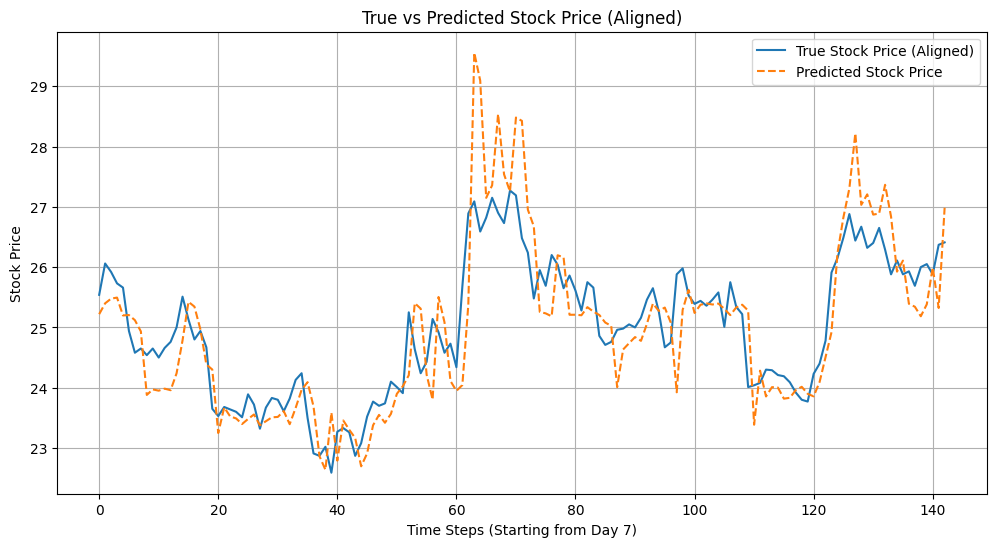

In [83]:
import matplotlib.pyplot as plt

Model.eval()
all_outputs = []
all_targets = []

with torch.no_grad():
    for x, y in test_dataloader:
        outputs = Model(x)  # 输入是归一化后的数据（与训练一致）
        # 反归一化（正确还原为原始股价）
        outputs = outputs * (train_y.max() - train_y.min()) + train_y.min()
        y_true = y * (train_y.max() - train_y.min()) + train_y.min()  # y是归一化后的值，反归一化正确

        all_outputs.extend(outputs.numpy().flatten())
        all_targets.extend(y_true.numpy().flatten())

plt.figure(figsize=(12, 6))
plt.plot(all_targets, label='True Stock Price (Aligned)')
plt.plot(all_outputs, label='Predicted Stock Price', linestyle='--')
plt.title('True vs Predicted Stock Price (Aligned)')
plt.xlabel('Time Steps (Starting from Day 7)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()